In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Dict, Tuple, Iterable
from evaluation_utils.hdf5_to_df import convert_hdf5_to_dfs, HDF5Keys, convert_hdf5_to_viewdict
from evaluation_utils.evaluation_utils import *
import evaluation_utils.pricing as BatterySim # because i moved to mw_to_kWh method there
import vis_utils
from vis_utils import *

from evaluation_utils import *

import h5py


In [3]:
market_colors = qualitative_colors
import cycler
cc_quali = cycler.cycler(color=qualitative_colors)
cc_div = cycler.cycler(color=diverging_colors)
cc_market = cycler.cycler(color=market_colors)

def eid_to_label(eid: str) -> str:
    if "pid" in eid:
        pid = int(eid.split("pid")[1][0])
        return "Prosumer %d" % (pid, )
    else: 
        return eid.split(".")[-1]

this_dataset = "COSSMIC"


# Vergleich Handelssummen 

In [4]:
KEY_NO_BATTERY = "No Battery"
KEY_SIMPLE = "Simple Battery"
KEY_SARIMA_SMART  = "SARIMA Smart Battery"
KEY_PERFECT_SMART = "Perfect SmartBattery"


from pathlib import PurePath
simulation_directory = PurePath("data/enerdag_sim")
simulation_directory = PurePath("data/enerdag_sim_prosumer/householdsim")
figure_folder = PurePath("figures/cossmic")

sim_name = "from_2016-03-01_to_2017-02-01_ConProPV_(3, 3, 0)_%s.hdf5"
def create_sim_file_name(specifier):
    return PurePath(simulation_directory, sim_name % specifier)

simulation_file_paths =  {
    KEY_NO_BATTERY: create_sim_file_name("NoBattery_0Wh"),
    KEY_SIMPLE: create_sim_file_name("SimpleBattery_10000Wh"),
    KEY_SARIMA_SMART: create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_10000Wh"), # Ursprünglich (1,0,0 ) (0,0,2)
  #  KEY_PERFECT_SMART: create_sim_file_name("CSV_perfect_SmartBattery_10000Wh") ,

}

simulation_file_paths_5kWh =  {
    KEY_NO_BATTERY: create_sim_file_name("NoBattery_0Wh"),
    KEY_SIMPLE: create_sim_file_name("SimpleBattery_5000Wh"),
    KEY_SARIMA_SMART: create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_5000Wh"), # Ursprünglich (1,0,0 ) (0,0,2)
   #  KEY_PERFECT_SMART: create_sim_file_name("CSV_perfect_SmartBattery_5000Wh") ,
}

simulation_dataframes = map_dict_values(simulation_file_paths, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))
simulation_dataframes_5kWh = map_dict_values(simulation_file_paths_5kWh, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))


simulation_dataframes[KEY_SARIMA_SMART].keys()

dict_keys(['Series/Rust_Sim-0.consumer_0', 'Series/Rust_Sim-0.consumer_1', 'Series/Rust_Sim-0.consumer_2', 'Series/Rust_Sim-0.pid1_prosumer_0', 'Series/Rust_Sim-0.pid3_prosumer_1', 'Series/Rust_Sim-0.pid4_prosumer_2'])

In [5]:
def sarima_model_str(ar, i, ma, p, q, d) -> str:
    return "CSV_(%d, %d, %d)_(%d, %d, %d, 24)_history_4_SmartBattery_10000Wh" %(ar, i, ma, p, q,d)

KEY_PERFECT = "Perfect"
KEY_B24 = "B24"
KEY_SARIMA_101 = "$(1,0,1)\\times (1,0,1)24$"
KEY_SARIMA_200 = "$(1,0,1)\\times (2,0,0)24$"

simulation_files_model_comparison =  {
    KEY_PERFECT: create_sim_file_name('CSV_perfect_SmartBattery_10000Wh'), 
    KEY_B24: create_sim_file_name('CSV_backschift_24h_SmartBattery_10000Wh'),
    KEY_SARIMA_101: create_sim_file_name(sarima_model_str(1,0,1,1,0,1)),
    KEY_SARIMA_200 : create_sim_file_name(sarima_model_str(1,0,1,2,0,0)), 
  
}
simulation_dataframes_model_comparison = map_dict_values(simulation_files_model_comparison, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))


**Notiz: Durch die Rundungsfehler in enerDAG wird auf das Jahr bei Consumer 1 etwa 38kWH zu wenige Energie auf dem Markt Nachgefragt**:

In [6]:
mw_consumption_to_kwh = sum(list(map(lambda x: BatterySim.mW_to_kWh(x, 300.), simulation_dataframes[KEY_NO_BATTERY]['Series/Rust_Sim-0.consumer_0'][HDF5Keys.CONSUMPTION][()])))
published_balance = simulation_dataframes[KEY_NO_BATTERY]['Series/Rust_Sim-0.consumer_0'][HDF5Keys.PUBLISHED_BALANCE][()].sum() / 1000
print("%.2f vs. %.2f" % (mw_consumption_to_kwh, -published_balance))

2558.05 vs. 2520.97


In [7]:
p0 = simulation_dataframes[KEY_SARIMA_SMART]['Series/Rust_Sim-0.pid1_prosumer_0']
p0eb = p0[HDF5Keys.ENERGY_BALANCE][()].sum() / 1000
p0_eb2 = pd.Series(p0[HDF5Keys.CONSUMPTION][()]).map(lambda x: BatterySim.mW_to_kWh(x, 300.)).sum() - pd.Series(p0[HDF5Keys.PRODUCTION][()]).map(lambda x: BatterySim.mW_to_kWh(x, 300.)).sum()
p0_eb2, p0eb

(-4205.63, 4224.369)

In [8]:
smart_bat = consumers_buy_from(simulation_dataframes[KEY_SARIMA_SMART]['Series/Rust_Sim-0.consumer_0'])
simple_bat = consumers_buy_from(simulation_dataframes[KEY_SIMPLE]['Series/Rust_Sim-0.consumer_0'])
no_bat = consumers_buy_from(simulation_dataframes[KEY_NO_BATTERY]['Series/Rust_Sim-0.consumer_2'])
print("SmartBattery", smart_bat, sum(smart_bat))
print("SimpleBattery", simple_bat, sum(simple_bat))
print("NoBattery", no_bat, sum(no_bat))

SmartBattery (-904012, -1436843) -2340855
SimpleBattery (-541519, -1979446) -2520965
NoBattery (-1442756, -3175320) -4618076


In [9]:
consumer_buy_balances = map_dict_values(simulation_dataframes, get_consumers_and_calc_buy_from)

consumer_buy_balances_5kWh = map_dict_values(simulation_dataframes_5kWh, get_consumers_and_calc_buy_from)
consumer_buy_balances

{'No Battery': (-2891080, -6588816),
 'Simple Battery': (-1932159, -7547737),
 'SARIMA Smart Battery': (-4013197, -5466699)}

# Konsumenten können mit Smart Battery bedeutend mehr Energie vom P2P Markt kaufen.

No Battery
	 [0.304969590383692, 0.695030409616308]
Simple Battery
	 [0.20381647646767434, 0.7961835235323257]
SARIMA Smart Battery
	 [0.4233376610882651, 0.5766623389117349]


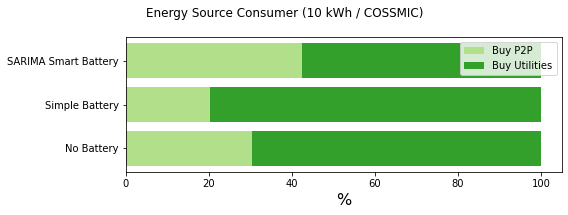

In [10]:


plot_energy_source_consumers(consumer_buy_balances, PurePath(figure_folder, "consumers_buy_from.png"), battery_size=10, dataset=this_dataset)
give_percentages_to_horizontal_bar(consumer_buy_balances)



No Battery
	 [0.304969590383692, 0.695030409616308]
Simple Battery
	 [0.21987509145669953, 0.7801249085433005]
SARIMA Smart Battery
	 [0.31979401461788187, 0.6802059853821181]


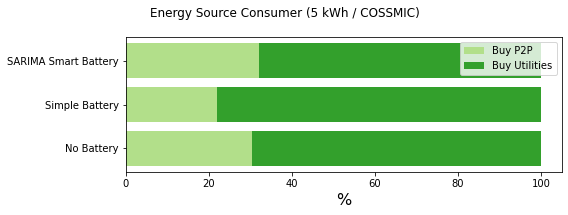

In [11]:

plot_energy_source_consumers(consumer_buy_balances_5kWh, PurePath(figure_folder, "consumers_buy_from_5kWh.png"), battery_size=5, dataset=this_dataset)


give_percentages_to_horizontal_bar(consumer_buy_balances_5kWh)

In [12]:

prosumers_sell_balance = map_dict_values(simulation_dataframes, nbhd_prosumers_sell_to)
prosumers_sell_balance_5kWh = map_dict_values(simulation_dataframes_5kWh, nbhd_prosumers_sell_to)

prosumers_sell_balance

{'No Battery': (2891080, 4735562),
 'Simple Battery': (1932159, 5694483),
 'SARIMA Smart Battery': (4013197, 3648131)}

# Prosumenten können mit Smart Battery mehr Energie an den P2P Markt verkaufen

No Battery
	 [0.3790764008589888, 0.6209235991410113]
Simple Battery
	 [0.25334334560347793, 0.7466566543965221]
SARIMA Smart Battery
	 [0.5238252428299637, 0.4761747571700363]


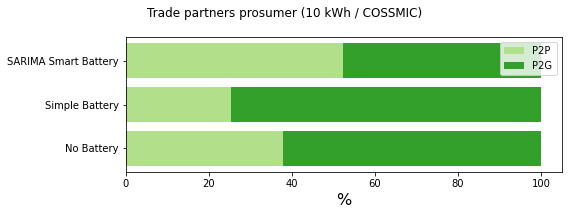

In [13]:


plot_energy_buyer_prosumer(prosumers_sell_balance, PurePath(figure_folder, "prosumers_sell_to.png"), battery_size=10, dataset=this_dataset)

give_percentages_to_horizontal_bar(prosumers_sell_balance)

In [44]:
for k, v in prosumers_sell_balance.items():
    print(k,v,sum(v))

No Battery (2891080, 4735562) 7626642
Simple Battery (1932159, 5694483) 7626642
SARIMA Smart Battery (4013197, 3648131) 7661328


No Battery
	 [0.3790764008589888, 0.6209235991410113]
Simple Battery
	 [0.27330416191031387, 0.7266958380896861]
SARIMA Smart Battery
	 [0.3968875446408057, 0.6031124553591942]


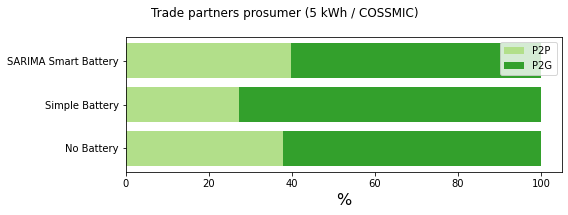

In [15]:


plot_energy_buyer_prosumer(prosumers_sell_balance_5kWh, PurePath(figure_folder, "prosumers_sell_to_5kWh.png"), battery_size=5, dataset=this_dataset)

give_percentages_to_horizontal_bar(prosumers_sell_balance_5kWh)

# Woher beziehen Prosumenten Ihre Energie?
Prosumenten müssen bei der Smart Battery nur unwesentlich mehr Energie vom Netz kaufen.

In [16]:
prosumers_energy_sources = map_dict_values(simulation_dataframes, filter_eid_and_get_energy_source)
nbhd_energy_source = map_dict_values(simulation_dataframes, nbhd_prosumers_energy_sources)
nbhd_energy_source_5kWh = map_dict_values(simulation_dataframes_5kWh, nbhd_prosumers_energy_sources)

No Battery: Adding 34.58 to P2G
No Battery: Adding 34.53 to P2G
No Battery: Adding 31.10 to P2G
No Battery: Adding 34.58 to P2G
No Battery: Adding 34.53 to P2G
No Battery: Adding 31.10 to P2G
No Battery: Adding 34.58 to P2G
No Battery: Adding 34.53 to P2G
No Battery: Adding 31.10 to P2G


**Consumption für die 5 Minuten ground truth daten und für die 1h ground truth daten sind unterschiedlich**

No Battery
	 [0.3726243483788671, 0.0, 0.022100874436169794, 0.6052747771849631]
Simple Battery
	 [0.3726243483788255, 0.3067636699922416, 0.0003999347804446739, 0.3202120468484883]
SARIMA Smart Battery
	 [0.3726243483788257, 0.2900423755287354, 0.00670113082404644, 0.3306321452683924]


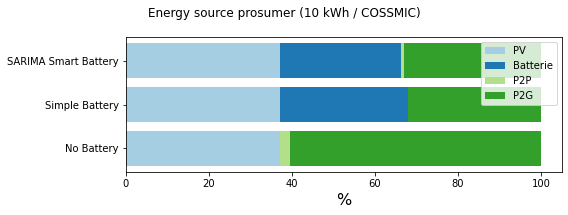

In [17]:
plot_energy_source_prosumers(nbhd_energy_source, PurePath(figure_folder, "prosumers_energy_from.png"), 10, this_dataset)
give_percentages_to_horizontal_bar(nbhd_energy_source)

No Battery
	 [0.3726243483788671, 0.0, 0.022100874436169794, 0.6052747771849631]
Simple Battery
	 [0.372624348378829, 0.2335164854663898, 0.0008042534372800735, 0.39305491271750104]
SARIMA Smart Battery
	 [0.37262434837883024, 0.21511278449773474, 0.004136437881865112, 0.40812642924156983]


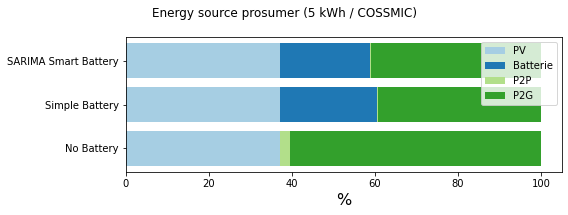

In [18]:
plot_energy_source_prosumers(nbhd_energy_source_5kWh, PurePath(figure_folder, "prosumers_energy_from_5kWh.png"), 5, this_dataset)
give_percentages_to_horizontal_bar(nbhd_energy_source_5kWh)

In [19]:
nbhd_energy_source_prediction_models = map_dict_values(simulation_dataframes_model_comparison, nbhd_prosumers_energy_sources)
print(nbhd_energy_source_prediction_models)

{'Perfect': [5949.917849358854, 4880.296650640881, 69.129, 5068.26], 'B24': [5949.917849358854, 4583.132650640882, 108.347, 5326.206], '$(1,0,1)\\times (1,0,1)24$': [5949.917849358854, 4635.50665064087, 100.794, 5281.384999999999], '$(1,0,1)\\times (2,0,0)24$': [5949.917849358854, 4631.281650640871, 107.00099999999999, 5279.403]}


## Vergleich Energiebezug aus Batterie 
Der Vergleich ist in Prozent zum Anteil der Energie die im Pefekten Modell aus der Batterie entnommen werden kann. 
Für den Vergleich mit der insgesamt konsumierten Energie hat $(1, 0, 2) \times (0,0,2)_{24 } \approx 1.1\%$ und $UEMA(168,0.8) \approx 2.5\%$

{'B24': -6.089056081477654, '$(1,0,1)\\times (1,0,1)24$': -5.015883613711577, '$(1,0,1)\\times (2,0,0)24$': -5.102456219896174}


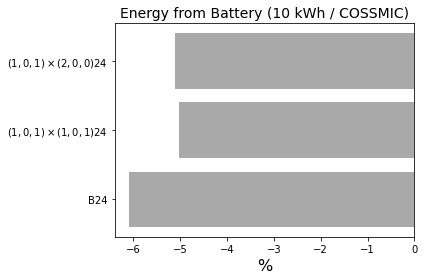

In [20]:
fig_path = PurePath(figure_folder, "prosumers_energy_from_model_comparison.png")
difference = plot_compare_energy_from_battery_to_perfect(nbhd_energy_source_prediction_models, 10, this_dataset, fig_path)
print(difference)

In [21]:
prosumers_sell_balance_comparison = map_dict_values(simulation_dataframes_model_comparison, nbhd_prosumers_sell_to)

prosumers_sell_balance_comparison

{'Perfect': (3929966, 3731850),
 'B24': (4086543, 3577271),
 '$(1,0,1)\\times (1,0,1)24$': (4036863, 3626159),
 '$(1,0,1)\\times (2,0,0)24$': (4013197, 3648131)}

{'B24': 3.9841820514477733,
 '$(1,0,1)\\times (1,0,1)24$': 2.7200489775229606,
 '$(1,0,1)\\times (2,0,0)24$': 2.1178554725409837}

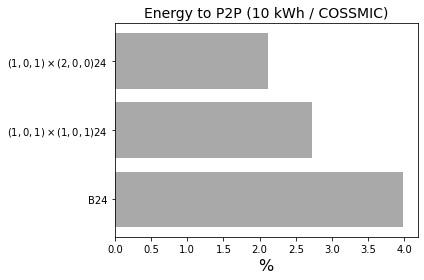

In [22]:
plot_compare_energy_to_p2p_to_perfect(prosumers_sell_balance_comparison, 10, this_dataset,PurePath(figure_folder, "prosumers_energy_sell_to_p2p_comparison.png") )

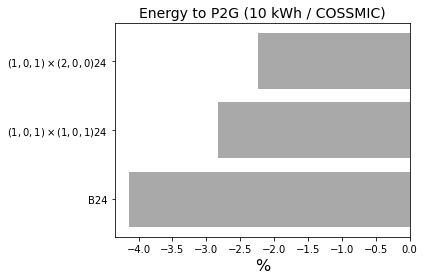

In [23]:
difference = plot_compare_energy_to_p2_grid_to_perfect(prosumers_sell_balance_comparison, 10, this_dataset, None)



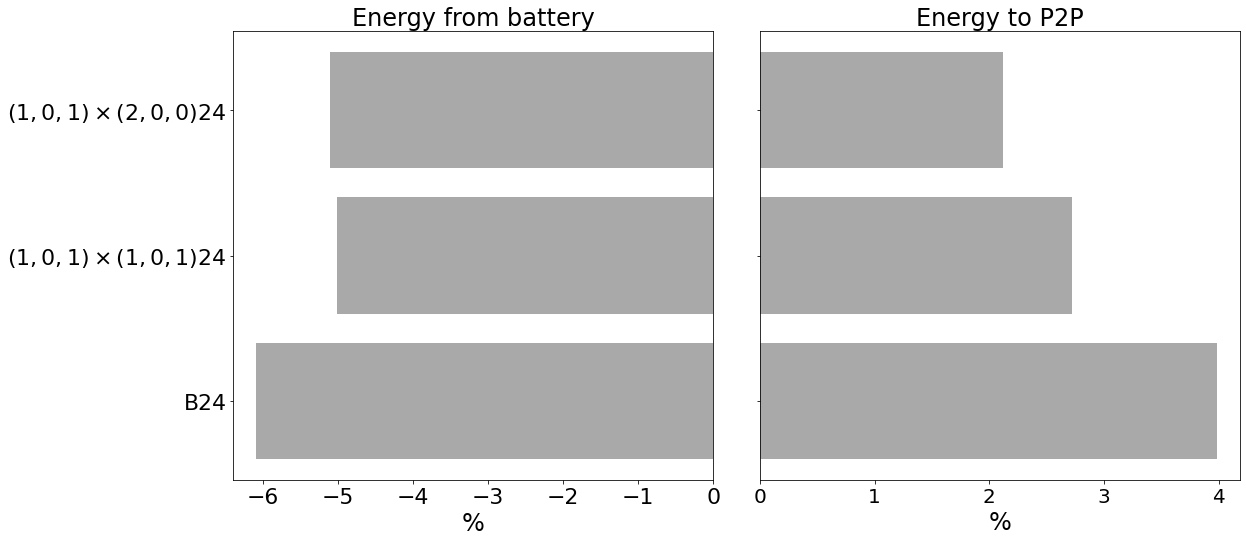

In [24]:
plot_energy_from_bat_and_to_p2p(nbhd_energy_source_prediction_models, prosumers_sell_balance_comparison, this_dataset, 10,PurePath(figure_folder, "prosumers_energy_to_p2p_and_from_battery_large.png") )

{'B24': 56.73161770024156, '$(1,0,1)\\times (1,0,1)24$': 45.80566766480057, '$(1,0,1)\\times (2,0,0)24$': 54.784533263897906}


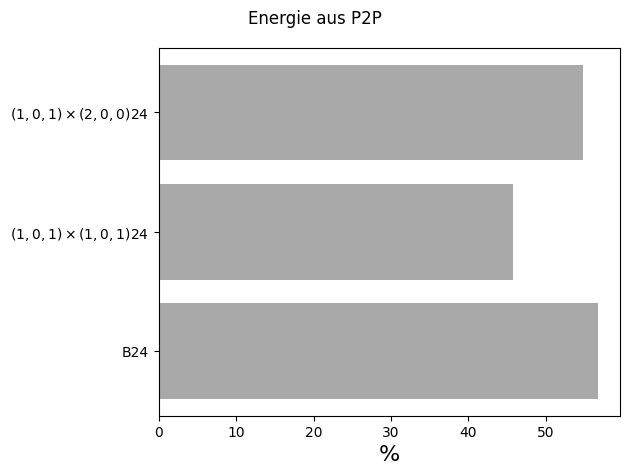

In [25]:
fig, ax = plt.subplots()
print(plot_compare_to_baseline( nbhd_energy_source_prediction_models, "Perfect", 2, ax))
fig.suptitle("Energie aus P2P")
ax.set_xlabel("%", fontsize=16)
fig.tight_layout()

In [26]:
prosumers_energy_sources = map_dict_values(simulation_dataframes_model_comparison, filter_eid_and_get_energy_source)


In [27]:
def plot_compare_to_baseline_prosumer_diff(data: Dict[str, List[Tuple[str, Tuple[float]]]], base_key, index:int,ax: plt.Axes, color="darkgray"): 
    ax.set_xscale("linear")

    tick_labels = []
    y = []
    left = []
    widths = []
    base =  data[base_key]
    colors = []
    labels = []
    for y_coord, (model, model_values) in enumerate(data.items()):
        if model == base_key:
            continue 
        
        widths_this_model = []
        for i, (base_id_data, prosumer_id_data) in enumerate(zip(base, model_values)):
            
            tick_labels.append(model if i == len(model_values) -1 else None)
            colors.append(qualitative_colors[i])
            #y.append(y_coord * 3 + i)
            y.append(y_coord)
            base_id, base_values = base_id_data
            prosumer_id, prosumer_values = prosumer_id_data

            labels.append(eid_to_label(prosumer_id) )
           
            assert base_id == prosumer_id
            widths_this_model.append(prosumer_values[index] - base_values[index])
        widths += widths_this_model
        widths_this_model = np.array(widths_this_model)
        left_coords = np.cumsum(widths_this_model) 
        left_coords = [0] + list(left_coords[:-1])

       


        left +=  list(left_coords)# [0] * len(widths_this_model)
    ax.barh(y=y[::3], width=widths[::3], tick_label=tick_labels[::3] ,left=left[::3], color=colors[::3], label=eid_to_label(labels[0]))
    ax.barh(y=y[1::3], width=widths[1::3], tick_label=tick_labels[1::3] ,left=left[1::3], color=colors[1::3], label=eid_to_label(labels[1]))
    ax.barh(y=y[2::3], width=widths[2::3], tick_label=tick_labels[2::3] ,left=left[2::3], color=colors[2::3], label=eid_to_label(labels[2]))
    ax.set_xlabel("kWh")
    #ax.barh(y=y, width=widths, left = left, tick_label=tick_labels, color=colors, label = labels  )



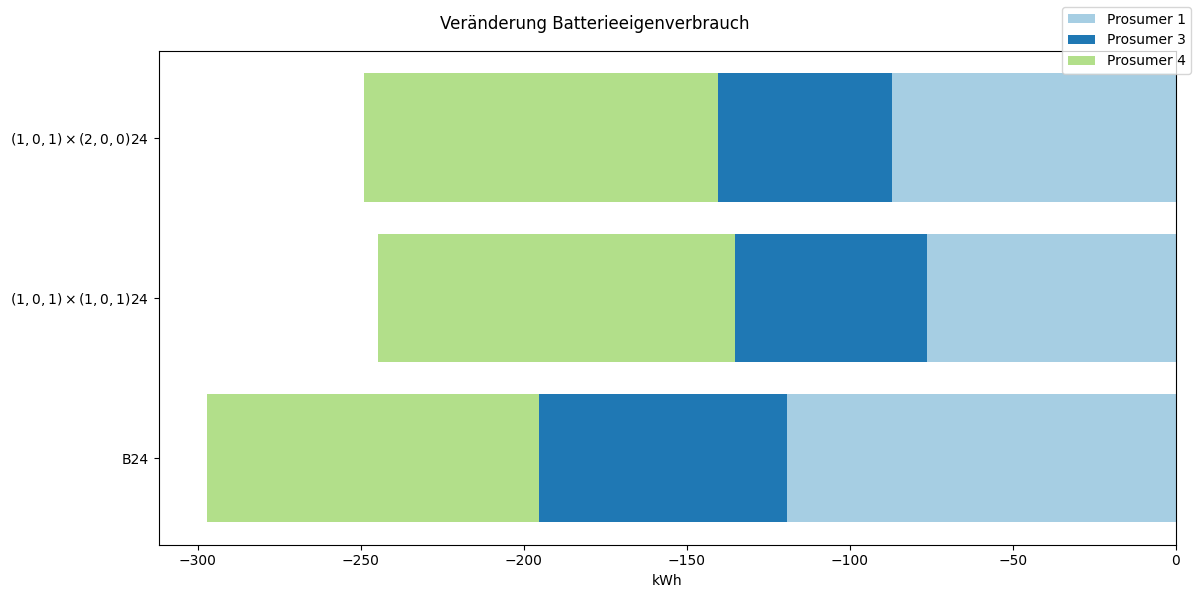

In [28]:

fig, axs = plt.subplots(1,1, figsize=(12,6))
ax = axs#[0]
plot_compare_to_baseline_prosumer_diff(prosumers_energy_sources, "Perfect",1, ax  )
#ax = axs[1]
#difference = plot_compare_to_baseline_prosumer_diff(nbhd_energy_source_prediction_models, "Perfect", 1, ax)

fig.legend()
fig.suptitle("Veränderung Batterieeigenverbrauch")
fig.tight_layout()

## Kombinierte Grafik für Energiequelle und Energieverkauf

In [29]:



nbhd_energy_source_combined = combine_10kWH_5kWh_dict(nbhd_energy_source, nbhd_energy_source_5kWh)
prosumers_sell_balance_combined = combine_10kWH_5kWh_dict(prosumers_sell_balance, prosumers_sell_balance_5kWh)

Sell Balance
Simple Battery (10kWh)
	 [0.25334334560347793, 0.7466566543965221]
SARIMA Smart Battery (10kWh)
	 [0.5238252428299637, 0.4761747571700363]
Simple Battery (5kWh)
	 [0.27330416191031387, 0.7266958380896861]
SARIMA Smart Battery (5kWh)
	 [0.3968875446408057, 0.6031124553591942]
No Battery
	 [0.3790764008589888, 0.6209235991410113]
Nbhd energy source
Simple Battery (10kWh)
	 [0.3726243483788255, 0.3067636699922416, 0.0003999347804446739, 0.3202120468484883]
SARIMA Smart Battery (10kWh)
	 [0.3726243483788257, 0.2900423755287354, 0.00670113082404644, 0.3306321452683924]
Simple Battery (5kWh)
	 [0.372624348378829, 0.2335164854663898, 0.0008042534372800735, 0.39305491271750104]
SARIMA Smart Battery (5kWh)
	 [0.37262434837883024, 0.21511278449773474, 0.004136437881865112, 0.40812642924156983]
No Battery
	 [0.3726243483788671, 0.0, 0.022100874436169794, 0.6052747771849631]


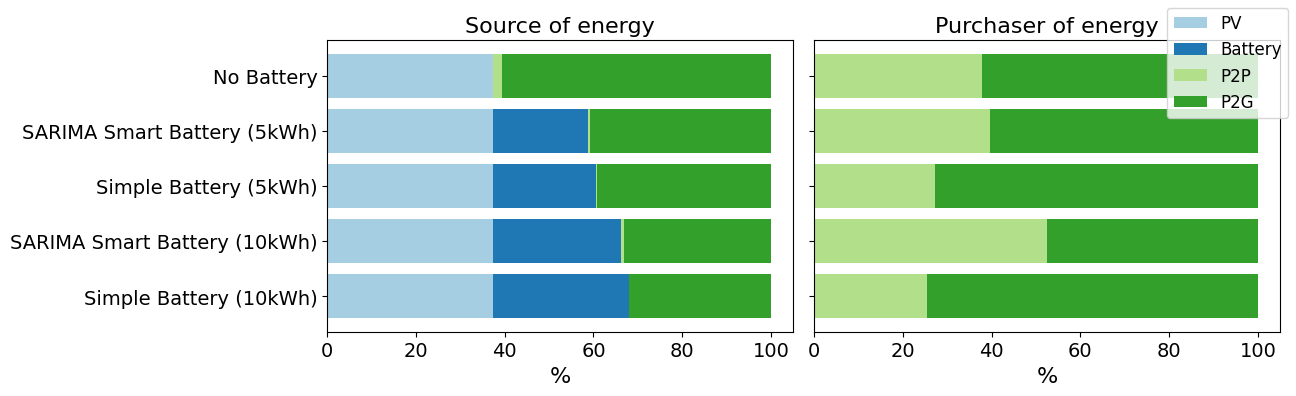

In [30]:
plot_combined_energy_source_sell_to(nbhd_energy_source_combined, prosumers_sell_balance_combined,  this_dataset, PurePath(figure_folder, "prosumers_energy_overview.png"))

print("Sell Balance")
give_percentages_to_horizontal_bar(prosumers_sell_balance_combined)

print("Nbhd energy source")
give_percentages_to_horizontal_bar(nbhd_energy_source_combined)


### Grafik für Energiebezug der Konsumenten mit 5kWh / 10kWh Kombiniert

In [31]:
plot_energy_source_consumers?


Signature:
plot_energy_source_consumers(
    data: Dict[str, Iterable[float]],
    save_to: Union[pathlib.PurePath, NoneType],
    battery_size=5,
    dataset='COSSMIC',
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
Docstring: <no docstring>
File:      ~/Workspace/Uni/Masterarbeit/simulation/visualization/vis_utils.py
Type:      function


In [32]:
consumers_buy_balances_combined = combine_10kWH_5kWh_dict(consumer_buy_balances, consumer_buy_balances_5kWh)

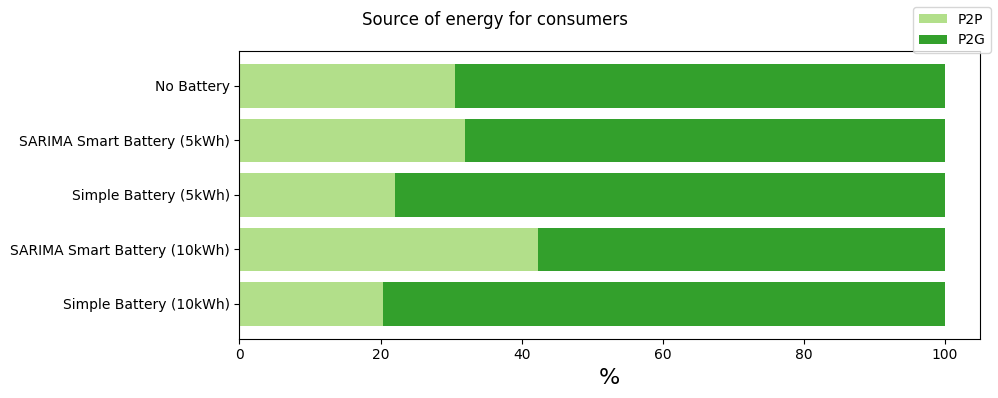

In [33]:
plot_combined_energy_source_consumers(consumer_buy_balances, consumer_buy_balances_5kWh, PurePath(figure_folder, "consumers_buy_from_combined.png"))


In [34]:
give_percentages_to_horizontal_bar(consumer_buy_balances)
print("5kWh")
give_percentages_to_horizontal_bar(consumer_buy_balances_5kWh)

No Battery
	 [0.304969590383692, 0.695030409616308]
Simple Battery
	 [0.20381647646767434, 0.7961835235323257]
SARIMA Smart Battery
	 [0.4233376610882651, 0.5766623389117349]
5kWh
No Battery
	 [0.304969590383692, 0.695030409616308]
Simple Battery
	 [0.21987509145669953, 0.7801249085433005]
SARIMA Smart Battery
	 [0.31979401461788187, 0.6802059853821181]


# Betrachte die durchschnittliche Handelsbilanz

In [35]:
import h5py
from evaluation_utils.hdf5_to_df import get_marketplace_df, MarketplaceKeys


In [36]:
marketplace_dfs = map_dict_values(simulation_file_paths, lambda x: get_marketplace_df(h5py.File(x)))



In [37]:
for sim, df in marketplace_dfs.items():
    print(sim, "Trades: ", df[MarketplaceKeys.NEIGHBORHOOD_TRADED].mean())

No Battery Trades:  1.8930205242334321
Simple Battery Trades:  0.9239202110121991
SARIMA Smart Battery Trades:  2.0406569403231125


In [38]:
quarters = [pd.date_range(start=pd.Timestamp("2016-03-01 00:00:00"), end=pd.Timestamp("2016-05-31 23:59:59"), freq="5MIN"),
            pd.date_range(start=pd.Timestamp("2016-06-01 00:00:00"),
                          end=pd.Timestamp("2016-08-31 23:59:59"), freq="5MIN"),
            pd.date_range(start=pd.Timestamp("2016-09-01 00:00:00"),
                          end=pd.Timestamp("2016-11-30 23:59:59"), freq="5MIN"),
            pd.date_range(start=pd.Timestamp("2016-12-01 00:00:00"), end=pd.Timestamp("2017-01-31 23:59:59"), freq="5MIN"), ]


for sim, df in marketplace_dfs.items():
    for i, quarter in enumerate(quarters):
        print(sim, "Trades: quarter ",i, df[MarketplaceKeys.NEIGHBORHOOD_TRADED][quarter].mean())
        

No Battery Trades: quarter  0 2.2363375603864735
No Battery Trades: quarter  1 2.6152626811594204
No Battery Trades: quarter  2 1.6707112332112333
No Battery Trades: quarter  3 0.6381608422939068
Simple Battery Trades: quarter  0 1.0846920289855073
Simple Battery Trades: quarter  1 1.6819519927536233
Simple Battery Trades: quarter  2 0.5874923687423688
Simple Battery Trades: quarter  3 0.05432347670250896
SARIMA Smart Battery Trades: quarter  0 2.197690217391304
SARIMA Smart Battery Trades: quarter  1 3.8488451086956523
SARIMA Smart Battery Trades: quarter  2 1.3698107448107448
SARIMA Smart Battery Trades: quarter  3 0.10915098566308244


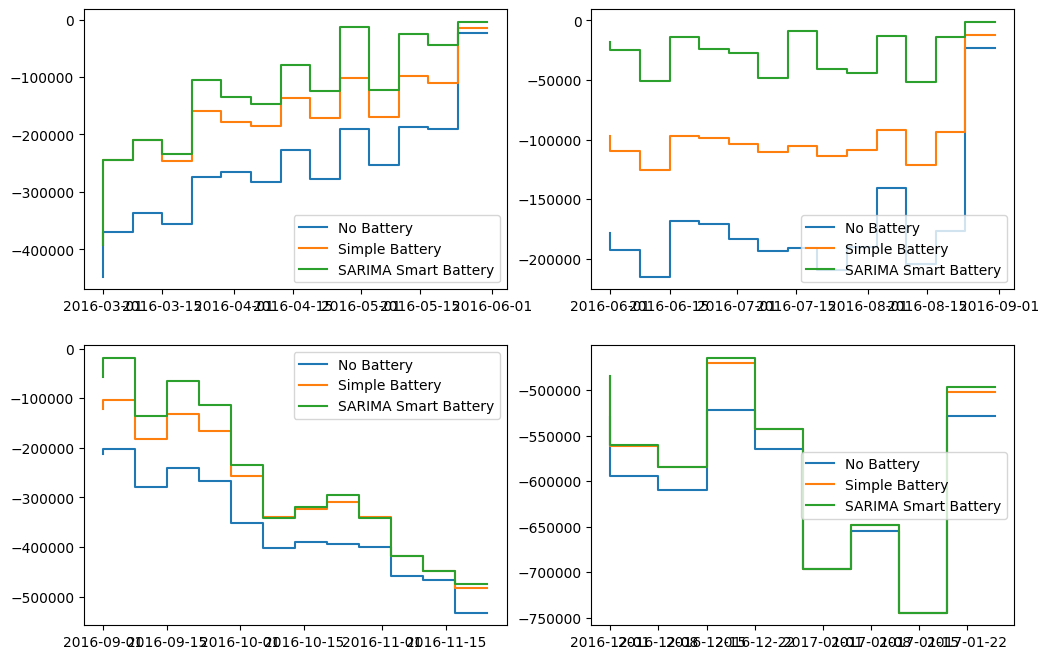

In [39]:
fig, axs = plt.subplots(2,2, figsize=(12,8))


for i, quarter in enumerate(quarters):
    ax = axs[i//2][i%2]    
    for sim, df in marketplace_dfs.items():
        df_quarter = df[MarketplaceKeys.NEIGHBORHOOD_ENERGY_BALANCE][quarter]
        missing_energy = df_quarter[df_quarter < 0]
        weekly = vis_utils.group_by_week(missing_energy, np.sum)
        ax.step(weekly.index, weekly, label=sim)
    ax.legend()


    

## Summe der Fehlenden Energie in Handelsrunden

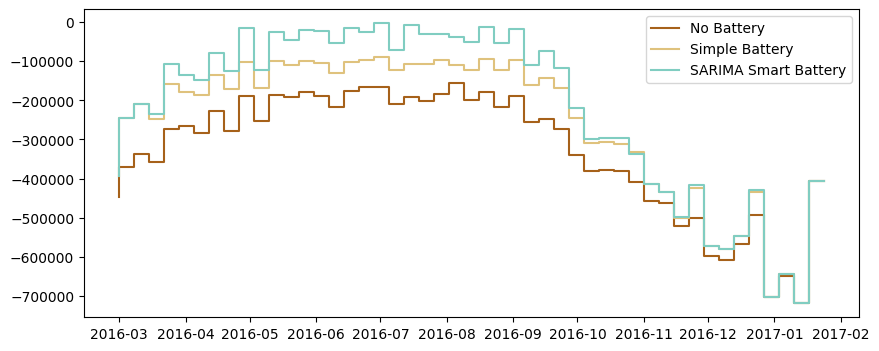

In [40]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_prop_cycle(cc_div)
for sim, df in marketplace_dfs.items():
        nbhd_balance = df[MarketplaceKeys.NEIGHBORHOOD_ENERGY_BALANCE][:pd.Timestamp("2017-01-28")]
        missing_energy = nbhd_balance[nbhd_balance < 0]
        weekly = vis_utils.group_by_week(missing_energy, np.sum)
        ax.step(weekly.index, weekly, label=sim)
ax.legend()

## Summe der Energie, die Prosumenten importieren müssen

In [41]:
simulation_dataframes[KEY_NO_BATTERY]

{'Series/Rust_Sim-0.consumer_0': <HDF5 group "/Series/Rust_Sim-0.consumer_0" (7 members)>,
 'Series/Rust_Sim-0.consumer_1': <HDF5 group "/Series/Rust_Sim-0.consumer_1" (7 members)>,
 'Series/Rust_Sim-0.consumer_2': <HDF5 group "/Series/Rust_Sim-0.consumer_2" (7 members)>,
 'Series/Rust_Sim-0.pid1_prosumer_0': <HDF5 group "/Series/Rust_Sim-0.pid1_prosumer_0" (9 members)>,
 'Series/Rust_Sim-0.pid3_prosumer_1': <HDF5 group "/Series/Rust_Sim-0.pid3_prosumer_1" (9 members)>,
 'Series/Rust_Sim-0.pid4_prosumer_2': <HDF5 group "/Series/Rust_Sim-0.pid4_prosumer_2" (9 members)>}

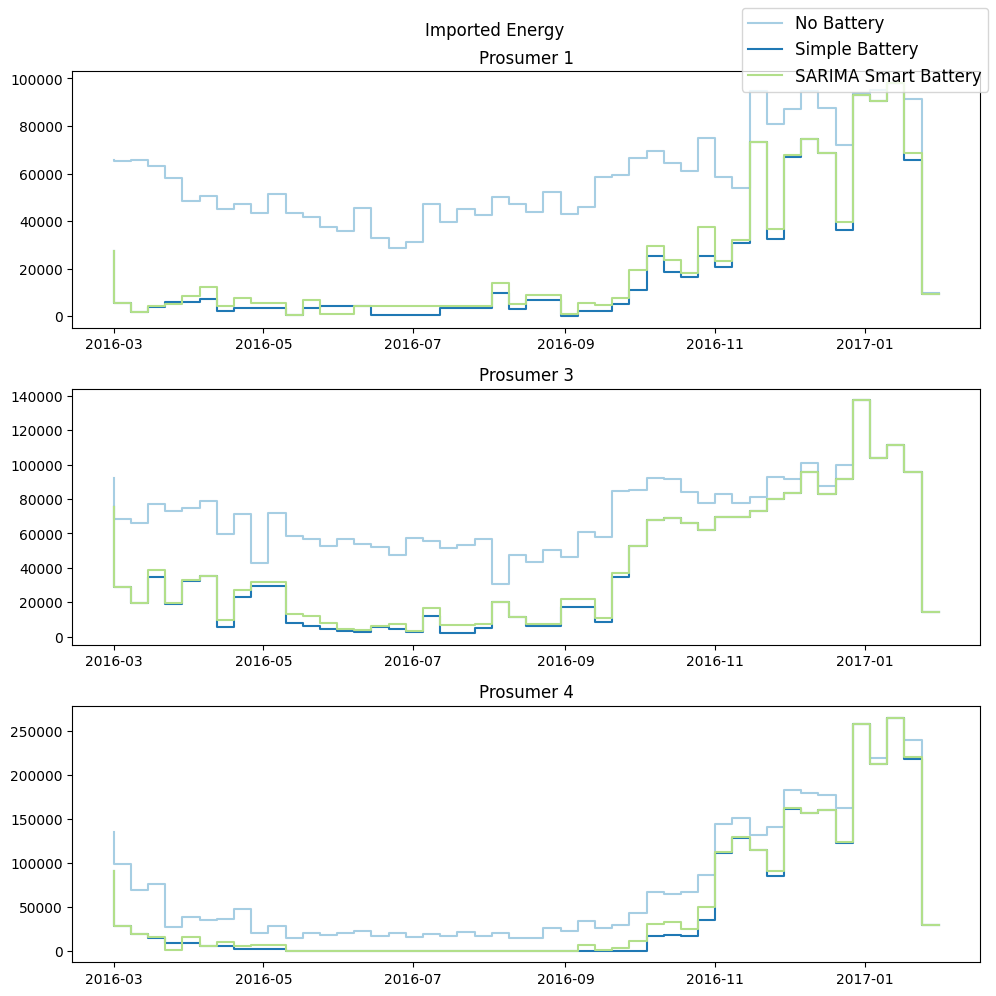

In [42]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
plt.rcdefaults()
for ax in axs:
    ax.set_prop_cycle(cc_quali)

for sim in simulation_dataframes:

    dfs = simulation_dataframes[sim]
    prosumers = [(id, df) for id, df in dfs.items() if "prosumer" in id]
    for i, (id, df) in enumerate(prosumers):
        ax = axs[i]
        balance = pd.Series(df[HDF5Keys.PUBLISHED_BALANCE], index=marketplace_dfs[list(marketplace_dfs.keys())[0]].index )
        balance = -balance[balance < 0]
        weekly = vis_utils.group_by_week(balance, np.sum)
        ax.step(weekly.index, weekly, label=sim if i == 0  else None)
        ax.set_title(eid_to_label(id))
fig.subplots_adjust(hspace=0.5)
fig.legend(fontsize=12);
fig.suptitle("Imported Energy")

fig.tight_layout()


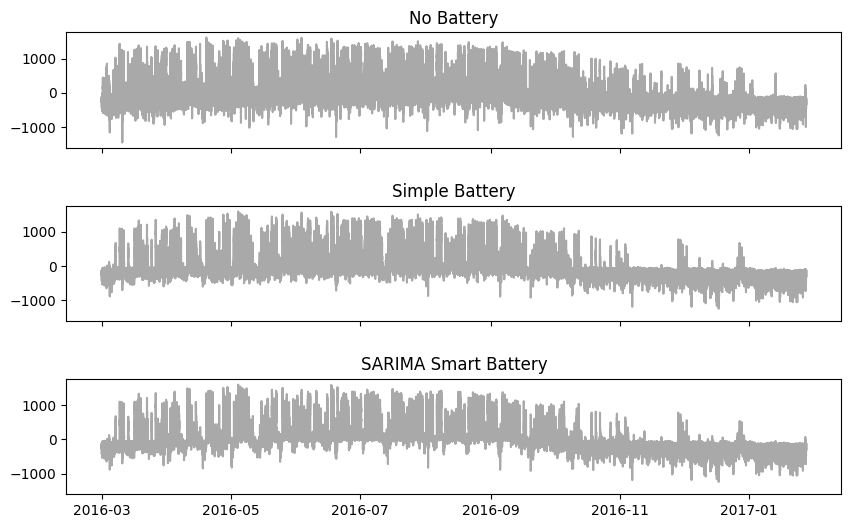

In [43]:
fig, axs = plt.subplots(3,1,figsize=(10,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5)
for i, (sim, df) in enumerate(marketplace_dfs.items()):
    ax = axs[i]
    nbhd_balance = df[MarketplaceKeys.NEIGHBORHOOD_ENERGY_BALANCE][:pd.Timestamp("2017-01-28")]
    ax.plot(nbhd_balance, 'darkgray')
    ax.set_title(sim)